In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:

import copy
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import find_dotenv, load_dotenv
from IPython.core.interactiveshell import InteractiveShell
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import (
    GridSearchCV,
    ShuffleSplit,
    cross_val_predict,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
)
from sklearn.tree import ExtraTreeRegressor

from src.visualization.visualize import (
    crossvalidate_pipeline_scores,
    plot_scores,
    train_and_plot_prediction_metrics,
)

# Setting styles
InteractiveShell.ast_node_interactivity = "all"
sns.set(style="whitegrid", color_codes=True, rc={"figure.figsize": (12.7, 9.27)})

random_state = 123



In [2]:

data = pd.read_csv(os.path.join("data", "processed", "iphone.csv"))


In [3]:

target = "iphonesentiment"

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=target), data[target], test_size=0.2, random_state=random_state
)


 # Comparison of Scalers

 * Creating a pipeline for three different scaler options
 * Robset Scaler has lower variance of metrics values than the two others
 and also better R2 and squared error values

In [4]:

scaler_pipelines = {
    "robust_scaler": make_pipeline(
        VarianceThreshold(), RobustScaler(), KNeighborsRegressor()
    ),
    "standard_scaler": make_pipeline(
        VarianceThreshold(), StandardScaler(), KNeighborsRegressor()
    ),
    "min_max_scaler": make_pipeline(
        VarianceThreshold(), MinMaxScaler(), KNeighborsRegressor()
    ),
}


Crossvalidating robust_scaler
Crossvalidating standard_scaler
Crossvalidating min_max_scaler


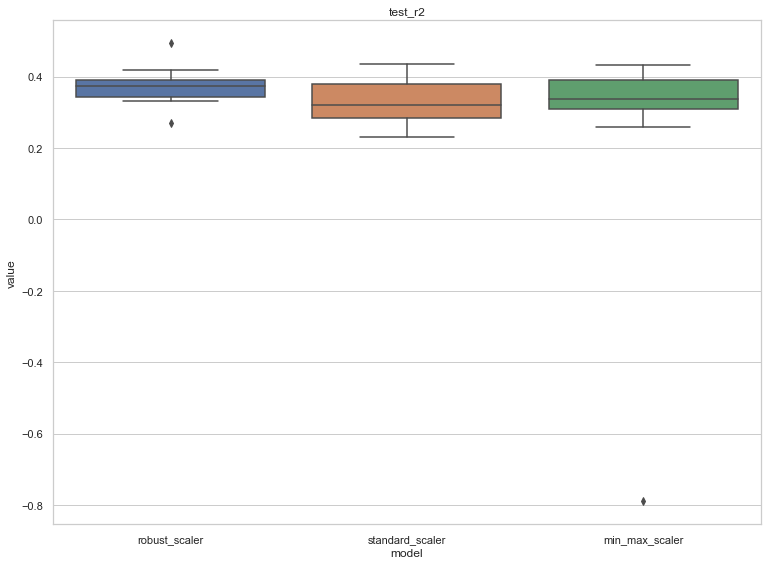

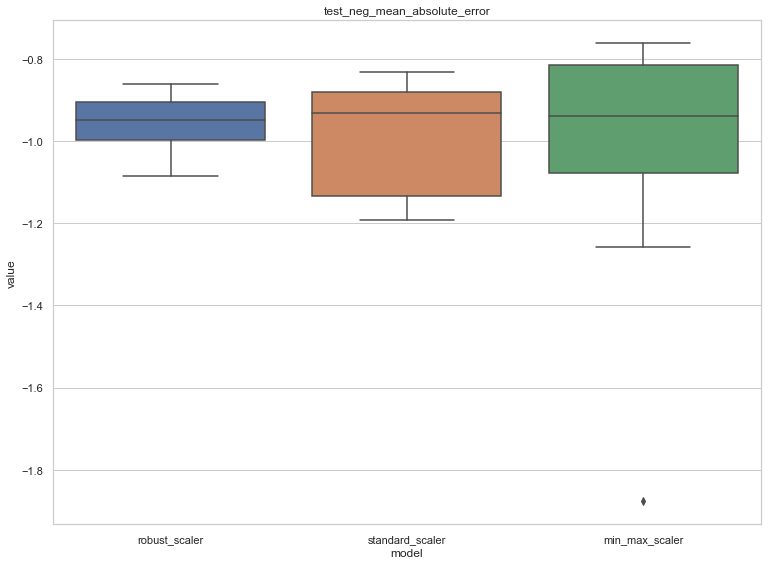

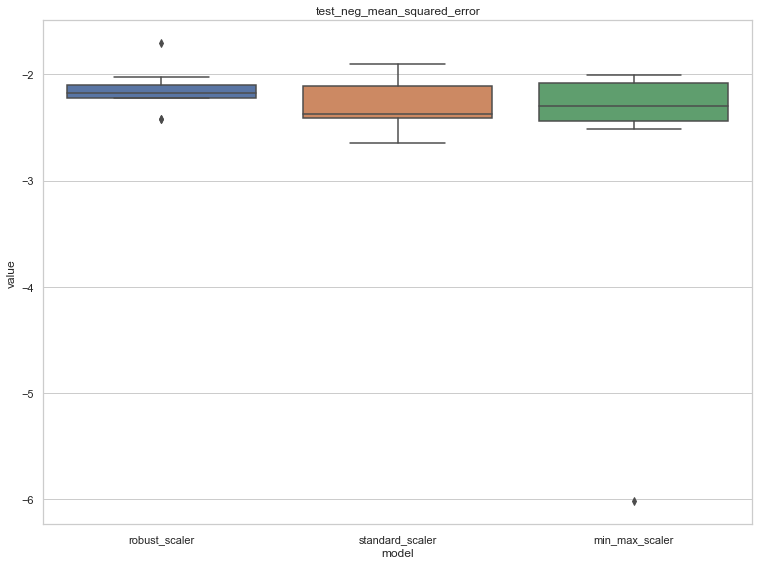

In [5]:

scores = crossvalidate_pipeline_scores(
    X=X_train,
    y=y_train,
    pipelines=scaler_pipelines,
    n_splits=10,
    random_state=random_state,
)

plot_scores(scores=scores)


 # Optimizing the Hyperparameters for Model Without Feature Selection

 * Using scoring metric of mean squared error

In [6]:

grid_search_pipeline = make_pipeline(
    VarianceThreshold(), RobustScaler(), KNeighborsRegressor()
)

parameters = {
    "kneighborsregressor__n_neighbors": list(range(4, 18)),
    "kneighborsregressor__p": list(range(1, 3)),
}
clf = GridSearchCV(
    grid_search_pipeline, parameters, cv=10, n_jobs=3, scoring="neg_mean_squared_error"
)
clf.fit(X_train, y_train)
print("\nBest Parameters:", clf.best_params_)



GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('variancethreshold',
                                        VarianceThreshold(threshold=0.0)),
                                       ('robustscaler',
                                        RobustScaler(copy=True,
                                                     quantile_range=(25.0,
                                                                     75.0),
                                                     with_centering=True,
                                                     with_scaling=True)),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                    


Best Parameters: {'kneighborsregressor__n_neighbors': 16, 'kneighborsregressor__p': 1}


 # Feature Selection

 * The chosen algorithm for recursive feature elimination
 and cross-validated selection makes a lot of difference
 * Extra Trees and Elastic Net hold a very small amount of columns. A bit too small
 * Random Forest seems better and keeps way more variables

In [7]:

selector = RFECV(
    ExtraTreeRegressor(random_state=random_state),
    step=1,
    cv=10,
    scoring="neg_mean_squared_error",
    n_jobs=3,
)
selector_extra_trees = selector.fit(X_train, y_train)
columns_to_keep_extra_trees = X_train.columns[selector_extra_trees.support_]
print("Columns to keep with Extra Trees:", columns_to_keep_extra_trees)
print(
    "Proportion of features kept with Extra Trees:",
    round(len(columns_to_keep_extra_trees) * 100 / len(X_train.columns), 1),
    "%",
)

selector = RFECV(
    ElasticNet(random_state=random_state),
    step=1,
    cv=10,
    scoring="neg_mean_squared_error",
    n_jobs=3,
)

selector_glmnet = selector.fit(X_train, y_train)
columns_to_keep_glmnet = X_train.columns[selector_glmnet.support_]
print("Columns to keep with Elastic Net:", columns_to_keep_glmnet)
print(
    "Proportion of features kept with Elastic Net:",
    round(len(columns_to_keep_glmnet) * 100 / len(X_train.columns), 1),
    "%",
)

selector = RFECV(
    RandomForestRegressor(n_estimators=100, random_state=random_state),
    step=1,
    cv=10,
    scoring="neg_mean_squared_error",
    n_jobs=3,
)
selector_rf = selector.fit(X_train, y_train)
columns_to_keep_rf = X_train.columns[selector_rf.support_]
print("Columns to keep with Random Forest:", columns_to_keep_rf)
print(
    "Proportion of features kept with Random Forest:",
    round(len(columns_to_keep_rf) * 100 / len(X_train.columns), 1),
    "%",
)



Columns to keep with Extra Trees: Index(['iphone', 'samsunggalaxy', 'iphonedispos'], dtype='object')
Proportion of features kept with Extra Trees: 10.7 %
Columns to keep with Elastic Net: Index(['googleperunc'], dtype='object')
Proportion of features kept with Elastic Net: 3.6 %
Columns to keep with Random Forest: Index(['iphone', 'samsunggalaxy', 'ios', 'googleandroid', 'iphonecampos',
       'samsungcampos', 'iphonecamneg', 'iphonecamunc', 'iphonedispos',
       'samsungdispos', 'iphonedisneg', 'samsungdisneg', 'iphonedisunc',
       'samsungdisunc', 'iphoneperpos', 'samsungperpos', 'iphoneperneg',
       'samsungperneg', 'iphoneperunc'],
      dtype='object')
Proportion of features kept with Random Forest: 67.9 %


 # Optimizing the Hyperparameters for Model with Feature Selection

 * Using scoring metric of mean squared error
 * Hyperparameters almost the same as in the model without feature selection

In [8]:

grid_search_pipeline = make_pipeline(
    VarianceThreshold(), RobustScaler(), KNeighborsRegressor()
)

parameters = {
    "kneighborsregressor__n_neighbors": list(range(4, 18)),
    "kneighborsregressor__p": list(range(1, 3)),
}
clf = GridSearchCV(
    grid_search_pipeline, parameters, cv=10, n_jobs=3, scoring="neg_mean_squared_error"
)
clf.fit(X_train[columns_to_keep_rf], y_train)
print("\nBest Parameters:", clf.best_params_)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('variancethreshold',
                                        VarianceThreshold(threshold=0.0)),
                                       ('robustscaler',
                                        RobustScaler(copy=True,
                                                     quantile_range=(25.0,
                                                                     75.0),
                                                     with_centering=True,
                                                     with_scaling=True)),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                    


Best Parameters: {'kneighborsregressor__n_neighbors': 15, 'kneighborsregressor__p': 1}


 # Performance of the optimized model compared to unoptimized model

 * Feature selection does not make much difference for crossvalidated results...
 * but is for the test set we see that the model without feature selection
 works better

Crossvalidating default_model
Crossvalidating default_model_feature_selection
Crossvalidating optimized_model
Crossvalidating optimized_model_feature_selection


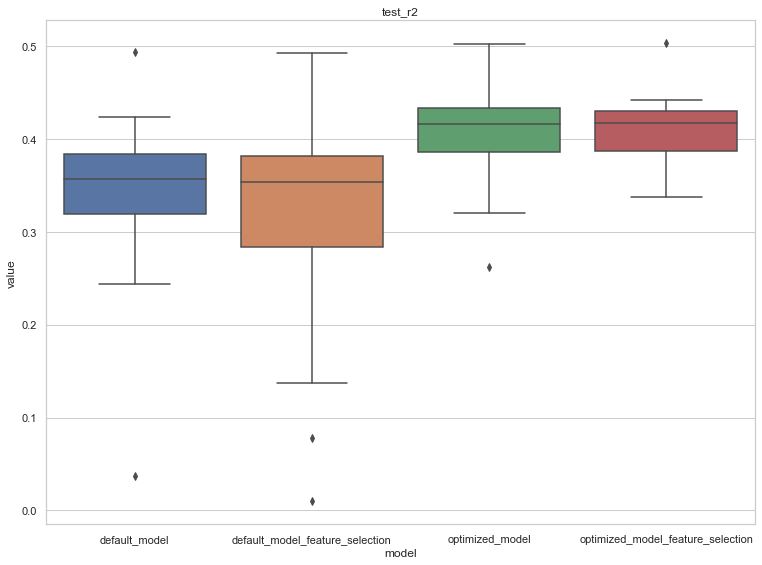

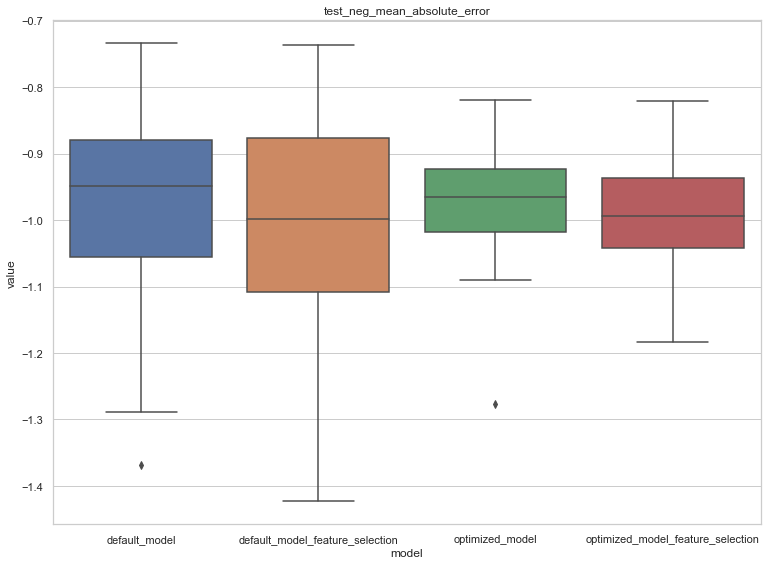

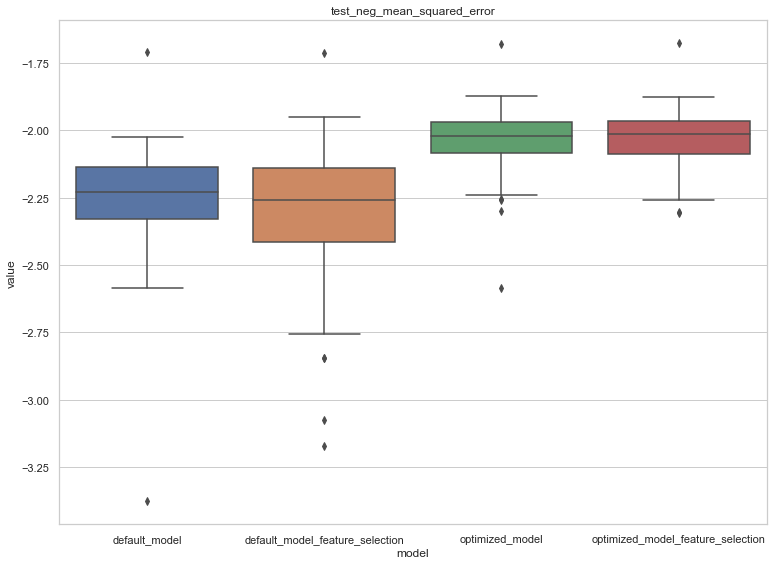

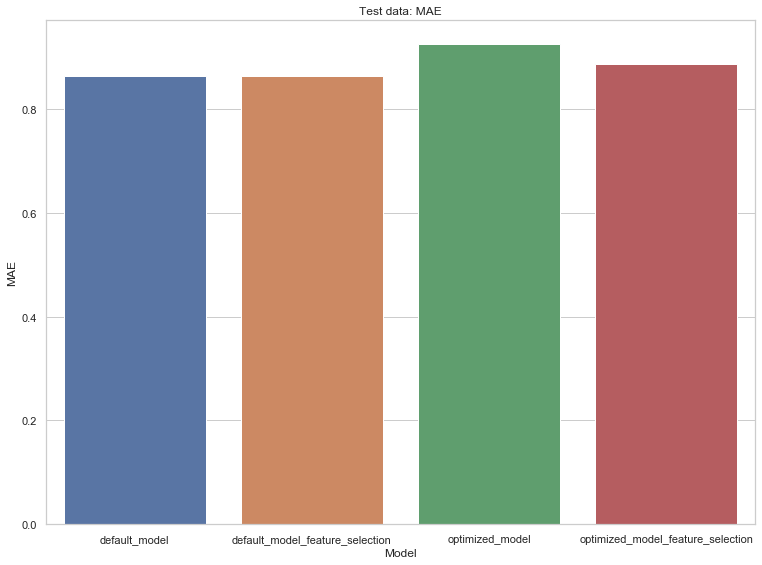

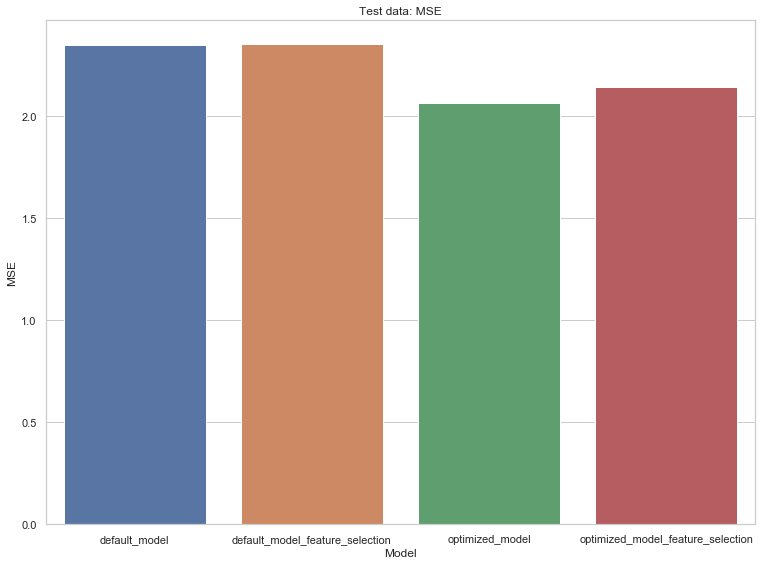

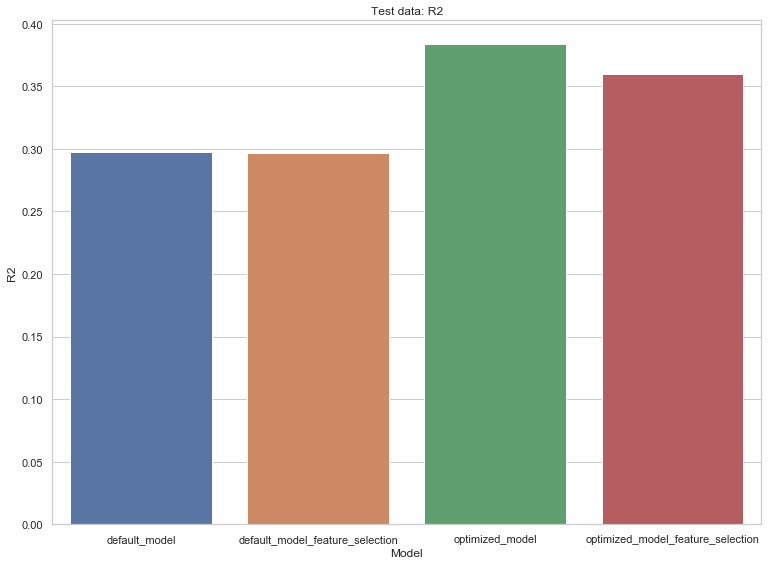

In [9]:


def drop_preselected_columns(X):
    return X[:, selector_rf.support_]


final_pipelines = {
    "default_model": make_pipeline(
        VarianceThreshold(), RobustScaler(), KNeighborsRegressor()
    ),
    "default_model_feature_selection": make_pipeline(
        VarianceThreshold(),
        RobustScaler(),
        FunctionTransformer(drop_preselected_columns, validate=False),
        KNeighborsRegressor(),
    ),
    "optimized_model": make_pipeline(
        VarianceThreshold(), RobustScaler(), KNeighborsRegressor(n_neighbors=15, p=1)
    ),
    "optimized_model_feature_selection": make_pipeline(
        VarianceThreshold(),
        RobustScaler(),
        FunctionTransformer(drop_preselected_columns, validate=False),
        KNeighborsRegressor(n_neighbors=15, p=1),
    ),
}

scores_optimized = crossvalidate_pipeline_scores(
    X=X_train,
    y=y_train,
    pipelines=final_pipelines,
    n_splits=30,
    random_state=random_state,
)

plot_scores(scores=scores_optimized)

train_and_plot_prediction_metrics(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    pipelines=final_pipelines,
)
